In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wrangle_fitbit as wf
import seaborn as sns
import csv
from sklearn import metrics
from math import sqrt

In [2]:
df = wf.get_activities_data(splain=True)

DATAFRAME SHAPE:
(225, 16)

DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 16 columns):
cals_burned          225 non-null float64
steps                225 non-null float64
dist                 225 non-null float64
flrs                 225 non-null float64
mins_sed             225 non-null float64
mins_light           225 non-null float64
mins_mod             225 non-null float64
mins_heavy           225 non-null float64
activity_cals        225 non-null float64
mins_tot             225 non-null float64
mins_off             225 non-null float64
week_day             225 non-null object
cals_idle            225 non-null float64
mins_idle            225 non-null float64
idle_cals_per_min    225 non-null float64
daily_rest_cals      225 non-null float64
dtypes: float64(15), object(1)
memory usage: 29.9+ KB
None

DATAFRAME DESCRIPTION:
                   count         mean          std         min          25%  \

In [3]:
df.head()

,cals_burned,steps,dist,flrs,mins_sed,mins_light,mins_mod,mins_heavy,activity_cals,mins_tot,mins_off,week_day,cals_idle,mins_idle,idle_cals_per_min,daily_rest_cals
date,,,,,,,,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0,1440.0,0.0,4-Thu,2069.0,1347.0,1.536006,2211.848552
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0,1440.0,0.0,5-Fri,1897.0,1158.0,1.638169,2358.963731
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0,890.0,550.0,6-Sat,2255.0,1252.0,1.801118,2593.610224
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0,1013.0,427.0,0-Sun,2249.0,1318.0,1.706373,2457.177542
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0,984.0,456.0,1-Mon,2285.0,1336.0,1.710329,2462.874251


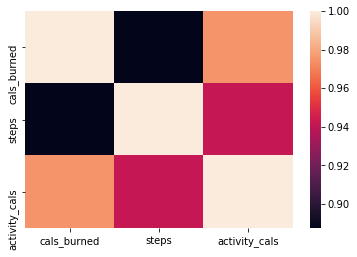

In [4]:
cor = df[['cals_burned','steps','activity_cals']].corr()
sns.pairplot(c0)